### AT&T  Detecteur de Spam

Nous allons devoir repérer, comprendre, analyser comment un modèle repère un spam ou non. Le but de ce projet est de créer des modèles de Deep Learning pour faire du preprocessing de Texte et comprendre les mechanismes derriere les spams. Nous allons classifier du text provenant de SMS pour detecter les spams en utilisant des modèles de machine learning supervisé. 

La target (spam ou non spam) est binaire donc nous sommes face devant un problème de classification binaire.

Nous tester différents modèles, allant de de modèles assez simple à modèles très complexes (transformers avec Bert) pour observer la différence entre les resultats. Nous pourrons aussi modifier le code interne des transformers pour faire du Fine tuning et ainsi se servir de leur entrainement sur de grandes quantités de données pour résoudre notre problèmatique de détection de spam

In [101]:
!python -m spacy download en_core_web_md -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [48]:
import pandas as pd
import numpy as np
import string
import spacy
import os
import string
import seaborn as sns
import datetime

# import en_core_web_sm : au chois de l'utilisateur s'il préfère utiliser un nombre de vocabulaire small ou medium pour l'étude
import en_core_web_md
from spacy.lang.fr.stop_words import STOP_WORDS

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

In [4]:
gpus = tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Le GPU est bien configuré avec Tensorflow (pour cela, nous avons utilisé CUDA (Compute Unified Device Architecture3) qui est une technologie de **GPGPU** (General-Purpose Computing on Graphics Processing Units), c'est-à-dire utilisant un processeur graphique (GPU) pour exécuter des calculs généraux à la place du processeur central (CPU)).

Nous avons utilisé CUDA Toolkit 12.0 qui nous permet de faire tourner notre carte graphique NVIDIA (il faut faire attention à l'installation des drivers qui doivent se faire manuellement.

L'avantage du GPU est qu'il peut augmenter x50 la vitesse de calcul qu'avec les CPU.

In [5]:
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
# df = pd.read_csv('/content/gdrive/MyDrive/datasets/at&t/spam_jedha_project.csv', encoding="latin-1")
df = pd.read_csv("spam_jedha_project.csv", encoding="latin-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Il y a très peu de variables et les 3 dernières ont l'air de ne pas servir (elles ne sont même pas correctement nommées). Faisons une brève analyse pour savoir si nous pouvons les retirer.

In [61]:
df.shape

(5572, 5)

In [62]:
print("colonne Unnamed_2 : ", df['Unnamed: 2'].value_counts().sum())
print("colonne Unnamed_3 : ", df['Unnamed: 3'].value_counts().sum())
print("colonne Unnamed_4 : ", df['Unnamed: 4'].value_counts().sum())

colonne Unnamed_2 :  50
colonne Unnamed_3 :  12
colonne Unnamed_4 :  6


Il y a quelques valeurs dans les 3 dernières colonnes mais elles sont trop peu nombreuses donc on va les supprimer

In [3]:
df = df.iloc[:, :2]

In [4]:
def test_null_values(df, print_=False, clean_nan=False):
    df_ = df.copy()
    for i, col in enumerate(df_.select_dtypes('object')):
        df_[col] = df_[col].apply(lambda x:np.nan if x=='' else x)
    if print_:
        print(df_.isna().sum()) 
    index_ = df_[pd.isnull(df_).any(1)].index
    if clean_nan:
        mask_nan = df_.index.isin(index_)
        df_ = df_[~mask_nan]
        df_ = df_.reset_index().drop(['index'], axis=1)
    return df_

In [5]:
test_null_values(df, print_=True, clean_nan=True)

v1    0
v2    0
dtype: int64


,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


Il n'y a aucune valeurs manquantes dans les 2 colonnes : on va les renommer pour plus de clarté

In [4]:
df.columns = ['target', 'message']

Nous allons egalement mapper les strings 'ham' et 'spam' en valeur binaire (cela evitera de faire un LabelBinarizer() au moment du `train_test_split`)

In [5]:
df['is_spam'] = df.target.apply(lambda x: 1 if x=='spam' else 0)

In [6]:
df['is_spam'].value_counts()

0    4825
1     747
Name: is_spam, dtype: int64

Comme nous sommes face à un dataset déséquilibré, nous essaierons dans un autre notebook SMOTE pour rééquilibrer les classes.

Passons rapidement à une EDA pour oberver quelques statistiques sur ce dataset.

### EDA

Analysons la longeur des messages pour savoir si c'est un élement important dans la detection des spams

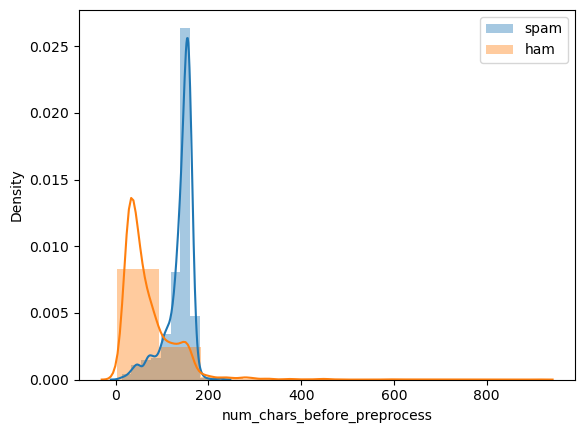

In [7]:
df['num_chars_before_preprocess'] = df['message'].apply(len)

df_spam = df[df['target']=='spam']
df_ham = df[df['target']=='ham']


plt.figure()
sns.distplot(df_spam['num_chars_before_preprocess'], label='spam', bins=10)
sns.distplot(df_ham['num_chars_before_preprocess'], label='ham',bins=10)
plt.legend()

On observe bien une différence entre les `spam` et les `ham`. Regardons plus en détails ces informations.

In [24]:
def display_len_information(df, col, spam_or_ham, char=False):
    temp='mots'
    if char:temp='caractères'
    print(f"longueur minimal de {temp} d'un message {spam_or_ham} : {int(df[col].min())}")
    print(f"longueur maximal de {temp} d'un message {spam_or_ham} : {int(df[col].max())}")
    print(f"longueur moyenne de {temp} d'un message {spam_or_ham} : {int(df[col].mean())}")
    print(f"ecart type longueur de {temp} message {spam_or_ham}   : {int(df[col].std())}")
    print(f"longueur 25% de {temp} d'un message {spam_or_ham}     : {int(np.quantile(df[col], 0.25))}")
    print(f"longueur motiée de {temp} d'un message {spam_or_ham}  : {int(np.quantile(df[col], 0.50))}")
    print(f"longueur 75% de {temp} d'un message {spam_or_ham}     : {int(np.quantile(df[col], 0.75))}")

#### Spam

In [88]:
display_len_information(df_spam, col='num_chars_before_preprocess', spam_or_ham='spam', char=True)

longueur minimal de caractères d'un message spam : 13
longueur maximal de caractères d'un message spam : 224
longueur moyenne de caractères d'un message spam : 138
ecart type longueur de caractères message spam   : 29
longueur 25% de caractères d'un message spam     : 132
longueur motiée de caractères d'un message spam  : 149
longueur 75% de caractères d'un message spam     : 157


#### Ham

In [89]:
display_len_information(df_ham, col='num_chars_before_preprocess', spam_or_ham='ham', char=True)

longueur minimal de caractères d'un message ham : 2
longueur maximal de caractères d'un message ham : 910
longueur moyenne de caractères d'un message ham : 71
ecart type longueur de caractères message ham   : 58
longueur 25% de caractères d'un message ham     : 33
longueur motiée de caractères d'un message ham  : 52
longueur 75% de caractères d'un message ham     : 92


In [73]:
fig = go.Figure()
fig.add_trace(go.Box(
    y=df_ham['num_chars_before_preprocess'],
    name="Ham",
    jitter=0.3,
    pointpos=-1.8,
    boxpoints='all', # represent all points
    marker_color='rgb(8,81,156)',
    line_color='rgb(8,81,156)'
))

fig.add_trace(go.Box(
    y=df_spam['num_chars_before_preprocess'],
    name="Spam",
    boxpoints='all', # only outliers
    marker_color='rgb(107,174,214)',
    line_color='rgb(107,174,214)'
))


fig.show()

On remarque plusieurs phénomènes :
    
D'abord, nous voyons que les messages qui sont des spams contiennent en moyenne plus de caractères. De plus, on observe une homogénité ddans le nombre de caractères d'un message spam.

Il y a quelques outliers en ham mais nous allons les garder pour l'instant (nous deciderons plus tard si nous devons les enlever, je ne pense pas que ca pose problème car les outliers sont de très grandes valeurs et ces valeurs appartiennent à la ditribution de Ham qui contient plus de caractères dans les message que Spam

Nous allons créer également 2 colonnes supplémentaires qui, cette fois ci, montre le nombre de mots par message (et non pas le nombre de caractères totaux) ainsi que le nombre moyen de caractères par mots.

In [8]:
df['len_message_before_preprocess'] = df['message'].apply(lambda x: len(x.split()))
df['len_word'] = df['num_chars_before_preprocess'] // df['len_message_before_preprocess']

In [9]:
df = df[df["message"].apply(lambda x: isinstance(x, str))]

In [10]:
df

,target,message,is_spam,num_chars_before_preprocess,len_message_before_preprocess,len_word
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,20,5
1,ham,Ok lar... Joking wif u oni...,0,29,6,4
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,28,5
3,ham,U dun say so early hor... U c already then say...,0,49,11,4
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,13,4
...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1,161,30,5
5568,ham,Will Ì_ b going to esplanade fr home?,0,37,8,4
5569,ham,"Pity, * was in mood for that. So...any other s...",0,57,10,5
5570,ham,The guy did some bitching but I acted like i'd...,0,125,26,4


In [11]:
df_spam = df[df['is_spam'] == 1]
df_ham = df[df['is_spam'] == 0]

In [23]:
df_spam

,target,message,is_spam,num_chars_before_preprocess,len_message_before_preprocess,len_word
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,28,5
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1,148,32,4
8,spam,WINNER!! As a valued network customer you have...,1,158,26,6
9,spam,Had your mobile 11 months or more? U R entitle...,1,154,29,5
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",1,136,26,5
...,...,...,...,...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...,1,90,16,5
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,1,160,33,4
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...,1,160,28,5
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...,1,147,28,5


In [25]:
display_len_information(df_spam, col='len_message_before_preprocess', spam_or_ham='spam')

longueur minimal de mots d'un message spam : 2
longueur maximal de mots d'un message spam : 35
longueur moyenne de mots d'un message spam : 23
ecart type longueur de mots message spam   : 5
longueur 25% de mots d'un message spam     : 22
longueur motiée de mots d'un message spam  : 25
longueur 75% de mots d'un message spam     : 28


In [26]:
display_len_information(df_ham, col='len_message_before_preprocess', spam_or_ham='ham')

longueur minimal de mots d'un message ham : 1
longueur maximal de mots d'un message ham : 171
longueur moyenne de mots d'un message ham : 14
ecart type longueur de mots message ham   : 11
longueur 25% de mots d'un message ham     : 7
longueur motiée de mots d'un message ham  : 11
longueur 75% de mots d'un message ham     : 19


In [27]:
print("---------------------------------------------SPAM---------------------------------------------")
print("moyenne du nombre de caractères (spam):", int(df_spam['num_chars_before_preprocess'].mean()))
print("moyenne du nombre de mots (spam)      :", int(df_spam['len_message_before_preprocess'].mean()))
print("moyenne de longueur d'un mot(spam)    :", int(df_spam['len_word'].mean()), '\n')

print("---------------------------------------------HAM---------------------------------------------")
print("moyenne du nombre de caractères (ham) :", int(df_ham['num_chars_before_preprocess'].mean()))
print("moyenne du nombre de mots (ham)       :", int(df_ham['len_message_before_preprocess'].mean()))
print("moyenne de longueur d'un mot(ham)     :", int(df_ham['len_word'].mean()))

---------------------------------------------SPAM---------------------------------------------
moyenne du nombre de caractères (spam): 138
moyenne du nombre de mots (spam)      : 23
moyenne de longueur d'un mot(spam)    : 5 

---------------------------------------------HAM---------------------------------------------
moyenne du nombre de caractères (ham) : 71
moyenne du nombre de mots (ham)       : 14
moyenne de longueur d'un mot(ham)     : 4


On voit que les SMS qui sont des `spams` contiennent **plus de caractères et de mots**.

### Data Viz

Cette fois-ci nous nous focalisons sur le nombre de mots par message

In [97]:
fig = px.pie(df, names='is_spam')
fig.show()

In [106]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=df_spam["len_message_before_preprocess"], histnorm='probability density'))
fig.add_vline(x=df_spam["len_message_before_preprocess"].mean(), line_width=3, line_dash="dash", line_color="blue")
fig.add_trace(go.Histogram(x=df_ham["len_message_before_preprocess"], histnorm='probability density'))
fig.add_vline(x=df_ham["len_message_before_preprocess"].mean(), line_width=3, line_dash="dash", line_color="red")
fig.update_layout(barmode='overlay')
fig.show()

Nous remarquons la même différence de distributions entre les spams et les hams : les spams représentent plus de mots que les hams

In [99]:
fig = px.histogram(df, x="is_spam", y=df['message'].apply(lambda x: len(x.split('..'))), color="is_spam")
fig.show()

Nous sommes bien devant deux classes très déséquilibrées avec une très grande majorité de non spam(donc de ham)

In [100]:
fig = px.box(df, x="is_spam", y="len_message_before_preprocess", points="all", color='is_spam')
fig.show()

Pareil que pour les caractères, nous nous retrouvons encore une fois face à une meilleur homogénité des spams (comme si tous les spams se ressemblent en longueur de caractères et de mots) et avec quelques outliers que nous decidons de laisser

Nous allons passer au preprocessing de texte pour le vectoriser, cad convertir des données de chaines de caractères en données numériques.

## Text Preprocessing

Une question se pose quand a la façon de proceder au preprocessing : Doit stemmatiser ou lemmatiser les messages ? quelles ponctuations garder ? Nous pourrions faire beaucoup d'essais mais il faut rester pragmatique et commencer à réaliser des taches simples et ensuite en essayer des plus complexes car il faut suivre un déroulement logique pour arriver à de bons résultats.

D'abord, nous avons le choix entre lemmatiser, stemmatizer ou ne rien faire..nous allons plus tard décider d'une methode et si tenir (nous changerons si nous nous sommes trompés et que nous obtenons de mauvais résultats).

On va choisir de lemmatiser car cela garde mieux le contexte que la stemmatization : le fait de retirer seulement le diminutif (la fin des mots qui se ressemblent avec les stems) nous fait perdre cette subtilités de savoir si c'est un homme,une femme, certains verbes qui ne ressortiront pas bien, ainsi que d'autres details nous laissent croire à une plus grande efficacité envers la lemmatization.

On importe le vocabulaire de taille "medium" grace à Spacy et nous allons pouvoir lemmatizer.

In [12]:
nlp = en_core_web_md.load()

### Lemmatization

In [13]:
# Supprime tous les caractères non alphanumerique exceptés les whitespaces
df["message_clean"] = df["message"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))

# Supprime les doubles spaces et spaces au début et la fin des strings
df["message_clean"] = df["message_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())

# Supprime les stop-words et remplace chaque mot par leur version lematiser
df["message_clean"] = df["message_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

In [16]:
df

,target,message,is_spam,num_chars_before_preprocess,len_message_before_preprocess,len_word,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,20,5,go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,0,29,6,4,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,28,5,free entry in 2 wkly comp to win fa cup final ...
3,ham,U dun say so early hor... U c already then say...,0,49,11,4,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,13,4,nah do not think he go to usf he live around h...
...,...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1,161,30,5,this be the 2nd time we have try 2 contact u u...
5568,ham,Will Ì_ b going to esplanade fr home?,0,37,8,4,will ì b go to esplanade fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",0,57,10,5,pity be in mood for that soany other suggestion
5570,ham,The guy did some bitching but I acted like i'd...,0,125,26,4,the guy do some bitching but act like d be int...


In [28]:
#df.to_csv('/content/gdrive/MyDrive/datasets/at&t/lematized_df.csv', index=False)
#df.to_csv('lemat_df.csv', index=False)
df = pd.read_csv('lemat_df.csv')

In [14]:
df['message_clean'] = df['message_clean'].astype(str)

### Tokenization sans Undersampling

Nous allons créer en premier lieu un train set et un test sans faire du rééchantillonnage puis, à partir du dataframe encodé, nous allons sous-rééchantillonner pour rééquilibrer les classes

In [19]:
X = df["message_clean"]
y = df['target']

On decide de tokenizer, cad transformer le texte en vecteurs de nombres dont la taille va être ajuster a celle du plus grand vecteur

In [20]:
max_words = 2000
max_len = len(max(df['message_clean'], key=len).split())

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words, oov_token="out_of_vocab")
tokenizer.fit_on_texts(X)
X_encoded = tokenizer.texts_to_sequences(X)

sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(X_encoded, maxlen=max_len)

In [24]:
sequences_padded.shape

(5572, 164)

In [22]:
df_encoded = pd.concat([pd.Series(X_encoded), df['is_spam']], axis=1)
df_encoded = df_encoded.rename(columns={0:'message_encoded', 'is_spam':'target'})
df_encoded

,message_encoded,target
0,"[20, 406, 1, 339, 576, 597, 65, 10, 1094, 90, ...",0
1,"[47, 295, 598, 407, 7, 1618]",0
2,"[50, 422, 10, 23, 670, 804, 3, 87, 1619, 996, ...",1
3,"[7, 222, 61, 25, 250, 1, 7, 155, 138, 57, 61]",0
4,"[848, 8, 6, 69, 36, 20, 3, 805, 36, 228, 200, ...",0
...,...,...
5567,"[35, 2, 5, 377, 58, 28, 11, 111, 23, 166, 7, 7...",1
5568,"[26, 102, 191, 20, 3, 1704, 714, 79]",0
5569,"[1, 2, 10, 1089, 13, 19, 1, 196, 1]",0
5570,"[5, 205, 8, 104, 1, 27, 1764, 53, 86, 2, 1455,...",0


In [25]:
X_total = sequences_padded
y_total = df_encoded['target']

In [145]:
X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(X_total, y_total, test_size=0.20, stratify=y_total, random_state=123)

In [146]:
le = LabelEncoder()
y_train_total = le.fit_transform(y_train_total)
y_train_total = y_train_total.reshape(-1,1)
y_test_total = le.transform(y_test_total)
y_test_total = y_test_total.reshape(-1,1)

In [147]:
X_train_total.shape, X_test_total.shape, y_train_total.shape, y_test_total.shape

((4457, 164), (1115, 164), (4457, 1), (1115, 1))

### Resampling

Nous ne pourrons pas utiliser SMOTE (ou SMOTE-NC pour les variables Numeriques-Catégorielle) car nous n'avons pas assez de variables.

Bien que notre approche SMOTE ne gère pas actuellement les datasets avec toutes les features nominales, elle a été généralisée pour gérer des ensembles de données mixtes de features continues et nominales. Nous appelons cette approche Synthetic Minority Over-sampling TEchnique-Nominal Continuous [SMOTE-NC]

1. **Calcul de la médiane** : calculez la médiane des écarts-types de toutes les caractéristiques continues pour la classe minoritaire. Si les caractéristiques nominales diffèrent entre un échantillon et ses voisins les plus proches potentiels, cette médiane est incluse dans le calcul de la distance euclidienne. Nous utilisons la médiane pour pénaliser la différence des caractéristiques nominales d'un montant qui est lié à la différence typique des valeurs des caractéristiques continues. 

2. **Calcul du voisin le plus proche(knn)** : calculez la distance euclidienne entre le vecteur de caractéristiques pour lequel les k plus proches voisins sont identifiés (échantillon de classe minoritaire) et les autres vecteurs de caractéristiques (échantillons de classe minoritaire) à l'aide de l'espace de caractéristiques continu. Pour chaque caractéristique nominale différente entre le vecteur de caractéristique considéré et son plus proche voisin potentiel, inclure la médiane des écarts-types précédemment calculés, dans le calcul de la distance euclidienne. 

Ainsi, il est évident que, pour que l'algorithme fonctionne, il a besoin d'au moins une caractéristique continue. Ce n'est pas le cas ici, donc l'algorithme échoue sans surprise lors de l'étape 1 (calcul médian), car il n'y a pas de caractéristiques continues à utiliser pour le calcul médian.

Nous allons donc devoir trouver d'autres techniques

### Tokenisation avec Undersampling

Comme nous nous retrouvons dans une situation ou ne pouvons utiliser SMOTE, nous allons essayer de faire de l'undersampling pour essayer d'équilibrer les classes `ham` et `spam`. Nous allons garder une partie de notre dataset pour l'evaluation finale avant de procéder au réechantillonnage.

On va créer une fonction qui permet d'enlever des echantillons de la classe majoritaire pour rééquilibrer la classe minoritaire. Nous avons, de base, 4825 samples représentant les `hams` et seulement 747 pour les `spams` : cela fait un rapport de 1 pour 6.45, cad qu'il y a 2 `spams` pour 13 `hams`. Logiquement, nous allons donc tester pour la valeur 6 (en arrondissant), on va donc devoir abaisser de 6 fois le nombre de `hams` dans notre dataset. Pour cela, nous allons multiplier le nombre de `spams` total par 6 pour prendre de 1 à 6 * len(`spams`) selon nos envies. Il faut savoir que 1 correspond à prendre 747 samples pour chaque classe et 6.45 correspond à prendre le dataset initial déséquilibré. Nous allons donc faire un compromis et prendre une valeur de 3.2 fois `hams` la quantité de `spams`. Nous testerons par la suite différentes valeurs et nous comparerons les résultats (En data science, nous sommes souvent obligé d'avancer à l'aveugle, cad de tester pleins de possibilités et de ne retenir que celle qui donne les meilleurs resultats).

Nous retenons donc la valeur de 3.2 puis nous aviserons en fonction des résultats obtenus


In [148]:
def preprocess_undersampling(X, shuffle=True, test_size=0.2, stratify=True, seed=None, operator=1, value_counts=False):
    """ Split les data en test et val """
    # On shuffle, si demandé, pour avoir un dataframe différent
    if shuffle:
        idx = np.arange(X.shape[0])
        np.random.shuffle(idx)
        X = X.iloc[idx, :]
        
    # Nous souhaitons d'abord tester l'undersampling uniquement sur le train set donc nous séparons en deux le dataset initial
    # Split en fonction du test_size pour créer un train set et un val set qui nous permettra de tester les resultats
    split_i = len(X) - int(len(X) // int(1 / test_size))
    train = X[:split_i] 
    val = X[split_i:]
    
    # le resampling par Undersampling : 
    # on prend la longueur de la classe minoritaire
    sample1 = train.loc[train['target']== 1,:]
    
    # on selectionne une partie de la classe majoritaire qui est une certaine proportion de la classe minoritaire
    sample0 = train.loc[train['target']== 0,:].sample(int(operator * len(sample1)))
    
    # on regroupe les 2 classes, on re shuffle et on réinitialise les index 
    df_undersampling = pd.concat([sample0,sample1], axis=0)
    # df_undersampling = df_undersampling.iloc[np.random.permutation(len(df_undersampling))] : autre technique pour shuffle
    df_undersampling = df_undersampling.sample(frac=1).reset_index(drop=True)
    
    if value_counts:
        print(df_undersampling['target'].value_counts())
    
    # longueur maximale de mots d'un message
    max_len = len(max(df_undersampling['message_encoded'], key=len))
    
    # padding sur le train pour que tous les vecteurs soient de même longueur        
    train_undersamp_padded = tf.keras.preprocessing.sequence.pad_sequences(df_undersampling['message_encoded'], padding="post", maxlen=max_len)
    
    # padding sur le validation set pour que l'on puisse tester nos resultats obtenus sur le train
    val_padded = tf.keras.preprocessing.sequence.pad_sequences(val['message_encoded'], padding="post", maxlen=max_len)
    
    # creation des targets : une pour le train_undersampling, une autre pour le val set sans undersampling
    target_train = df_undersampling['target']
    target_val = val['target']
    
    # on va encoder les target (nous le faisons je crois que les nouvelles versions de sklearn le font automatiquement)
    le = LabelEncoder()
    
    # on fit sur le train et on transforme la target_train
    y_train_undersamp = le.fit_transform(target_train)
    y_train_undersamp = y_train_undersamp.reshape(-1, 1)
     
    # on transforme seulement sur la target val 
    y_val = le.transform(target_val)
    y_val = y_val.reshape(-1, 1)          
    
    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(train_undersamp_padded, y_train_undersamp, test_size=0.25, stratify=y_train_undersamp, random_state=123)
    
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    
    return X_train, X_test, y_train, y_test, val_padded, y_val


In [149]:
df_encod = df_encoded.copy()

In [151]:
X_train, X_test, y_train, y_test, val_padded, y_val = preprocess_undersampling(df_encoded, test_size=0.2, stratify=True, seed=None, operator=4, value_counts=True)

0    2448
1     612
Name: target, dtype: int64
(2295, 164) (765, 164) (2295, 1) (765, 1)


Nous allons créer des **batchs de 64** (chiffre fixé au hasard). Il faut savoir qu'il existe trois type de batchs:</br>

**mode batch** : la taille du lot est égale à l'**ensemble de données total**, ce qui rend les valeurs d'itération et d'époque équivalentes

**mode mini-batch** : la taille du lot est **supérieure à un** mais **inférieure à la taille totale** de l'ensemble de données. Généralement, un nombre qui peut être divisé par la taille totale de l'ensemble de données. 

**mode stochastique** : la taille du lot est **égale à un**. Par conséquent, le gradient et les paramètres du réseau de neurones sont mis à jour après chaque échantillon.

In [152]:
BATCH_SIZE = 64

train_batch_undersampling = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)).batch(BATCH_SIZE)
val_batch_undersampling = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

train_batch_total = tf.data.Dataset.from_tensor_slices((X_train_total, y_train_total)).shuffle(len(X_train_total)).batch(BATCH_SIZE)
val_batch_total = tf.data.Dataset.from_tensor_slices((X_test_total, y_test_total)).batch(BATCH_SIZE)

In [153]:
AUTOTUNE = tf.data.AUTOTUNE

train_batch_undersampling = train_batch_undersampling.cache().prefetch(buffer_size=AUTOTUNE)
val_batch_undersampling = val_batch_undersampling.cache().prefetch(buffer_size=AUTOTUNE)

train_batch_total = train_batch_total.cache().prefetch(buffer_size=AUTOTUNE)
val_batch_total = val_batch_total.cache().prefetch(buffer_size=AUTOTUNE)

### Model 1 : Embedding

Nous allons commencer par créer un modèle assez simple avec une couche d'Embedding (avec 256 dimensions) suivie d'un Global Average Pooling, de plusieurs couches Dense et de Dropout pour réduire l'overfitting. 

#### Embedding

L'**Embedding est comme une sorte de One Hot Encoder de mots avec reduction de la dimensionnalité**. Lorsque nous traitons des données textuelles, nous devons les convertir en nombres avant d'alimenter tout modèle de machine learning ou de deep learning. Pour simplifier, les mots peuvent être comparés à des variables catégorielles. Nous utilisons un One Hot Encoding pour convertir les features catégorielles en nombres. On crée des entités fictives pour chacune des catégories et les remplissons avec des 0 et des 1. Si on utilise un One Hot Encoding sur des mots dans des données textuelles, nous aurons une feature one hot pour chaque mot, ce qui signifie 2000 features pour un vocabulaire de 2000 mots. Ce n'est pas une approche d'Embedding réalisable car elle nécessite un grand espace de stockage pour les vecteurs de mots et réduit l'efficacité du modèle.

La **layer d'Embedding** nous permet de **convertir chaque mot en un vecteur de longueur fixe de taille définie**. Le vecteur résultant est **dense avec des valeurs réelles** au lieu de seulement 0 et 1. La longueur fixe des vecteurs de mots nous aide à **mieux représenter les mots avec des dimensions réduites**. De cette façon, la **layer d'Embedding fonctionne comme une table de recherche**. Les **mots** sont les **clés** de ce tableau, tandis que les **vecteurs de mots denses** sont les **valeurs**. 

On ajoute à cette layer d'Embedding un **Global Average Pooling** qui fait la moyenne sur l'ensemble des valeurs de tous les tokens de la sequence de mots. 

Puis nous faisons passer ces valeurs dans plusieurs couches Denses successives (avec fonctions d'activation `relu` qui, par sa simplicité, permet une activation lisse en sortie de neurone, une meilleure propagation du gradient (contrairement à `sigmoid` qui est plus sensible aux *vanishing gradient problem*, de par son risque de saturation par forward / back propagation), permet également un calcul plus rapide et efficace du gradient (car il execute seulement des comparaison, addition et multiplication) et reste invariant au niveau de scaling par sa formule mathématique max(0,**a**) pour **a** entrant) en alternant des couches de Dropout (ce qui evite au modèle de trop se complexifier et donc d'eviter ou de reduire l'overfitting) pour augmenter la compléxité du reseau de neurones que l'on va faire converger vers une sortie sigmoid classique qui permet de faire de la classification par une loi de Bernouilli en sortant la probabilité d'appartenir à une classe de manière binaire. 

Passons à la construction du modèle (d'abord le général puis, en second temps, le modèle undersampler)

#### Dataset original

In [119]:
vocab_size = 2000

model_1_original = tf.keras.Sequential([        
    keras.layers.Embedding(vocab_size+1, 256, input_shape=[X_train_total.shape[1],],name="embedding"),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation="sigmoid")
])

In [120]:
model_1_original.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 164, 256)          512256    
                                                                 
 global_average_pooling1d_4   (None, 256)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_26 (Dense)            (None, 128)               32896     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_27 (Dense)            (None, 64)                8256      
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                      

Pour pouvoir compiler le modèle, nous allons devoir definir 3 éléments: la loss function, l'optimizer et la métrique de performance
    
* **loss** : Nous sommes sur un problème de classification binaire donc nous utiliserons la **Binary cross entropy** qui utilise la formule de Bernouilli pour prédire la probabilité qu'une donnée appartienne à une classe A ou classe B. 
    
    
* **optimizer** : Nous utiliserons **Adam** qui permet d'ajuster le learning rate (le pas dans la descente de gradient) : si lors de la descente, le gradient devient plus grand, Adam reduira le learning rate(réduira la vitesse de la descente de gradient). Au contraire, si tout va bien et que nous convergeons vers la bonne direction, Adam augmentera le learning rate pour accélérer la descente.
    
* **metric** : Nous allons utiliser trois type de métrique de performance : l'accuracy qui donne la tendance des predictions mais elle ne suffit pas car, pour des classes déséquilibrées, il est très facile d'avoir un bon accuracy en se trompant sur le taux de faux positifs et le taux de faux negatifs. Nous devons donc rajouter deux metriques qui permettront d'obtenir une verification de ces resultats qui sont le **Recall** (Taux de spams correctement prédits, cad combien de faux spams parmis tous les spams) et la **Precision** (Taux de prediction de spams correctes, cad les vrais spams parmis tous les positifs). Il existe un questionnement sur le fait de privilégier l'un ou l'autre : Doit t'on laisser des spams pour éviter de classifier un email important en spam ou doit t'on eviter à tout prix les spams pour éviter une infection par un virus informatique. Je pense que cette question est liée à la compétence d'une personne à savoir detecter des spams en regardant ses mails. Donc cette précision sera laisser libre à l'utilisateur de juger sa pertinence.
    
De plus, nous utiliserons Tensorboard pour afficher différents paramètres tel que le suivi et visualisation de métriques (loss, metrique d'accuracy (precision, recall), une visualisation du graphe du modèle (ops et couches), un affichage d'histogrammes de pondérations, de biais ou d'autres tenseurs à mesure qu'ils évoluent dans le temps, ect.. il y a beaucoup de paramètres à oberver avec Tensorboard que nous allons devons voir créer un tracker de performance ainsi qu'un logger pour accéder à ces infos.

In [87]:
def compile_logging(model, model_name, optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=None, core={}):
    # plugings hparams pour Tensorboard, le tracking des perfs des modèles
    from tensorboard.plugins.hparams import api as hp
    
    if metrics is None:
        metrics = ['accuracy']
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    # log_dir="/content/gdrive/MyDrive/DEEP LEARNING/logs/models/" + model_name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
    log_dir="./logs/models/" + model_name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    
    callback_tb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    callback_params = hp.KerasCallback(log_dir, core)
    
    print (f"{model_name} logged")
    return callback_tb, callback_params, log_dir

In [122]:
metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]

callback_tb, callback_hp, log_dir = compile_logging(model=model_1_original, model_name="Embedding avec multiple denses layers", metrics=metrics, core={'dim_embedding':256, 'nb_dense_units':233, 'dropout':0.35})

Embedding avec multiple denses layers logged


#### TRAINING DU MODELE

In [123]:
model_1_original.fit(
    train_batch_total,
    epochs=50,
    verbose=1,
    callbacks=[callback_tb, callback_hp],
    validation_data=val_batch_total)

Epoch 1/50
66/66 [==============================] - 2s 24ms/step - loss: 0.3562 - accuracy: 0.8564 - precision: 0.1154 - recall: 0.0107 - val_loss: 0.1546 - val_accuracy: 0.8658 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
66/66 [==============================] - 1s 14ms/step - loss: 0.1049 - accuracy: 0.9478 - precision: 0.8977 - recall: 0.6893 - val_loss: 0.0682 - val_accuracy: 0.9828 - val_precision: 0.9358 - val_recall: 0.9358
Epoch 3/50
66/66 [==============================] - 1s 12ms/step - loss: 0.0434 - accuracy: 0.9852 - precision: 0.9577 - recall: 0.9304 - val_loss: 0.0761 - val_accuracy: 0.9806 - val_precision: 0.9082 - val_recall: 0.9519
Epoch 4/50
66/66 [==============================] - 1s 13ms/step - loss: 0.0314 - accuracy: 0.9897 - precision: 0.9726 - recall: 0.9500 - val_loss: 0.0753 - val_accuracy: 0.9792 - val_precision: 0.8990 - val_recall: 0.9519
Epoch 5/50
66/66 [==============================] - 1s 13ms/step - loss: 0.0265 - accuracy: 0.9921 -

66/66 [==============================] - 1s 17ms/step - loss: 0.0031 - accuracy: 0.9990 - precision: 0.9964 - recall: 0.9964 - val_loss: 0.1688 - val_accuracy: 0.9770 - val_precision: 0.8818 - val_recall: 0.9572
Epoch 38/50
66/66 [==============================] - 1s 15ms/step - loss: 0.0033 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.9964 - val_loss: 0.1385 - val_accuracy: 0.9792 - val_precision: 0.8950 - val_recall: 0.9572
Epoch 39/50
66/66 [==============================] - 1s 13ms/step - loss: 0.0017 - accuracy: 0.9993 - precision: 0.9982 - recall: 0.9964 - val_loss: 0.1280 - val_accuracy: 0.9864 - val_precision: 0.9421 - val_recall: 0.9572
Epoch 40/50
66/66 [==============================] - 1s 14ms/step - loss: 0.0018 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.9964 - val_loss: 0.1839 - val_accuracy: 0.9742 - val_precision: 0.8647 - val_recall: 0.9572
Epoch 41/50
66/66 [==============================] - 1s 15ms/step - loss: 0.0027 - accuracy: 0.9995 - precision: 0.9

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/models/

On obtient de très bon scores, que ca soit au niveau de l'accuracy, la precision ou le recall qui sont proche de 1. on observe toute fois un leger overfitting car on est sur des scores 1 sur le train set et de 0.95 sur le val set 

In [72]:
def preds(model, treshold, X_test, y_test):
    return y_test, np.where(model.predict(X_test) > treshold, 1, 0)

In [65]:
def display_matrix_and_scores(y_true, y_pred):
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    print(f'Accuracy : {accuracy_score(y_true,y_pred)}')
    print(f'Precision : {precision_score(y_true,y_pred)}')
    print(f'Recall : {recall_score(y_true,y_pred)}')

In [116]:
def display_infos(modl, threshold, X_train, X_test, y_train, y_test):
    # y_true, y_pred = preds(model_1_undersamp, 0.5, val_padded, y_val)
    y_train_true, y_train_pred = preds(modl, threshold, X_train, y_train)
    y_test_true, y_test_pred = preds(modl, threshold, X_test, y_test)

    scores_train = modl.evaluate(X_train, y_train, verbose=0)
    scores_test = modl.evaluate(X_test, y_test, verbose=0)

    print("----------------------------------------\n                 Sur le Train set            \n----------------------------------------")
    print(f'loss = {scores_train[0]}\nAccuracy = {scores_train[1]}\nPrecision = {scores_train[2]}\nRecall = {scores_train[3]}')
    print()
    print("----------------------------------------\n                 Sur le Test set            \n----------------------------------------")
    print(f'loss = {scores_test[0]}\nAccuracy = {scores_test[1]}\nPrecision = {scores_test[2]}\nRecall = {scores_test[3]}')
    
    return y_train_true, y_train_pred, y_test_true, y_test_pred

In [126]:
y_train_true, y_train_pred, y_test_true, y_test_pred = display_infos(model_1_original, 0.5, X_train_total, X_test_total, y_train_total, y_test_total);

44/44 [==============================] - 0s 3ms/step
----------------------------------------
                 Sur le Train set            
----------------------------------------
loss = 0.0009033180540427566
Accuracy = 0.9997606873512268
Precision = 1.0
Recall = 0.9982143044471741

----------------------------------------
                 Sur le Test set            
----------------------------------------
loss = 0.1258016675710678
Accuracy = 0.9870782494544983
Precision = 0.9518716335296631
Recall = 0.9518716335296631


Accuracy : 1.0
Precision : 1.0
Recall : 1.0


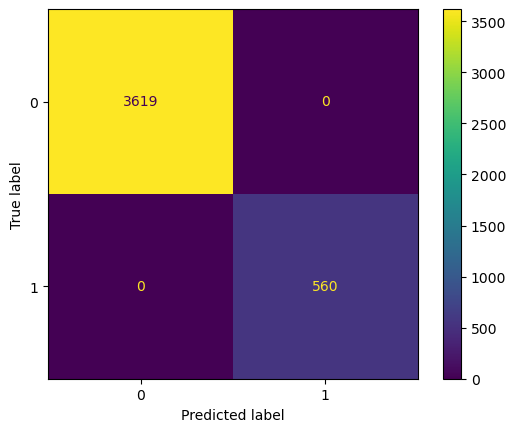

In [82]:
display_matrix_and_scores(y_train_true, y_train_pred)

Accuracy : 0.9856424982053122
Precision : 0.9417989417989417
Recall : 0.9518716577540107


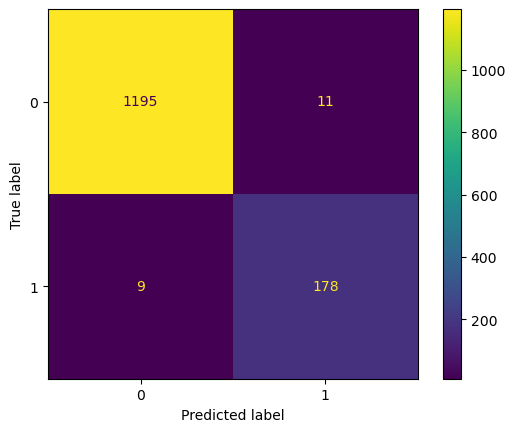

In [79]:
display_matrix_and_scores(y_test_true, y_test_pred)

On remarque encore une fois une baisse de performance sur le test ce qui est normal. Cette baisse reste très légère et nous pouvons dire que le modèle arrive à très bien détecter les spams des hams ! Le recall est plus haut que la precision, ce qui signifie que le modèle arrive plus facilement à detecter les faux positifs que les faux négatifs, donc laisse mois passer des spams quitte à classifier un non spam en spam.

Nous laissons l'utilisateur modifier à sa guise la valeur du seuil de preds pour diminuer ou augmenter la probabilité de classifier les spams en maximisant la précision des prédictions

#### Dataset undersampled

Cette fois ci, nous allons observer les résultats des echantillons après sous-échantillonnage pour comparer les différences de scores

In [100]:
vocab_size = 2000

model_1_undersamp = tf.keras.Sequential([        
    keras.layers.Embedding(vocab_size+1, 256, input_shape=[X_train.shape[1],],name="embedding"),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation="sigmoid")
])

In [101]:
model_1_undersamp.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 256)          512256    
                                                                 
 global_average_pooling1d_3   (None, 256)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_18 (Dense)            (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                      

In [102]:
callback_tb, callback_hp, log_dir = compile_logging(model=model_1_undersamp, model_name="Embedding avec multiple denses layers (undersampled)", metrics=metrics, core={'dim_embedding':256, 'nb_dense_units':233, 'dropout':0.35})

Embedding avec multiple denses layers (undersampled) logged


In [103]:
model_1_undersamp.fit(
    train_batch_undersampling,
    epochs=50,
    verbose=1,
    callbacks=[callback_tb, callback_hp],
    validation_data=val_batch_undersampling)

Epoch 1/50
30/30 [==============================] - 2s 35ms/step - loss: 0.6235 - accuracy: 0.8391 - precision: 0.6815 - recall: 0.3164 - val_loss: 0.5275 - val_accuracy: 0.7613 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
30/30 [==============================] - 1s 20ms/step - loss: 0.5307 - accuracy: 0.7621 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5030 - val_accuracy: 0.7613 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
30/30 [==============================] - 1s 19ms/step - loss: 0.4931 - accuracy: 0.7621 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4320 - val_accuracy: 0.7613 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
30/30 [==============================] - 1s 19ms/step - loss: 0.3609 - accuracy: 0.7621 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.2543 - val_accuracy: 0.7613 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
30/30 [==============================] - 

30/30 [==============================] - 1s 21ms/step - loss: 0.0037 - accuracy: 0.9989 - precision: 0.9977 - recall: 0.9977 - val_loss: 0.1793 - val_accuracy: 0.9790 - val_precision: 1.0000 - val_recall: 0.9122
Epoch 38/50
30/30 [==============================] - 1s 21ms/step - loss: 0.0043 - accuracy: 0.9989 - precision: 0.9977 - recall: 0.9977 - val_loss: 0.1352 - val_accuracy: 0.9790 - val_precision: 0.9856 - val_recall: 0.9257
Epoch 39/50
30/30 [==============================] - 1s 20ms/step - loss: 0.0040 - accuracy: 0.9989 - precision: 1.0000 - recall: 0.9955 - val_loss: 0.1129 - val_accuracy: 0.9742 - val_precision: 0.9459 - val_recall: 0.9459
Epoch 40/50
30/30 [==============================] - 1s 18ms/step - loss: 6.0148e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1344 - val_accuracy: 0.9774 - val_precision: 0.9855 - val_recall: 0.9189
Epoch 41/50
30/30 [==============================] - 1s 19ms/step - loss: 2.5322e-04 - accuracy: 1.0000 - precis

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/models/

In [127]:
y_train_true, y_train_pred, y_test_true, y_test_pred = display_infos(model_1_undersamp, 0.5, X_train, X_test, y_train, y_test);

20/20 [==============================] - 0s 3ms/step
----------------------------------------
                 Sur le Train set            
----------------------------------------
loss = 0.010358854196965694
Accuracy = 0.9956942796707153
Precision = 1.0
Recall = 0.9819004535675049

----------------------------------------
                 Sur le Test set            
----------------------------------------
loss = 0.2624211609363556
Accuracy = 0.975806474685669
Precision = 1.0
Recall = 0.8986486196517944


Accuracy : 0.9956942949407965
Precision : 1.0
Recall : 0.9819004524886877


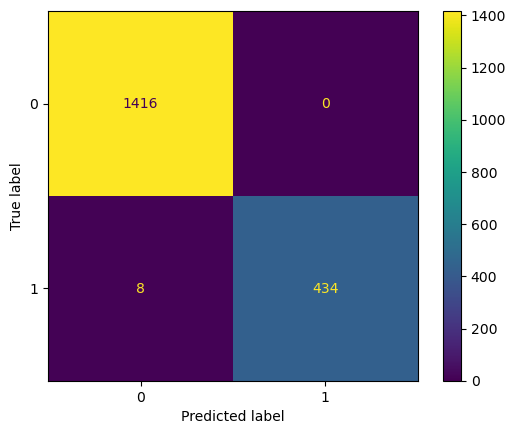

In [105]:
display_matrix_and_scores(y_train_true, y_train_pred)

Accuracy : 0.9758064516129032
Precision : 1.0
Recall : 0.8986486486486487


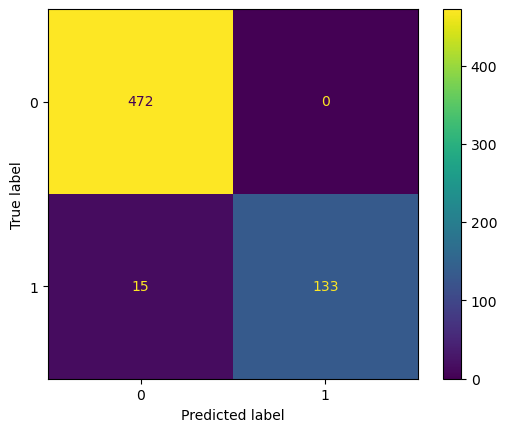

In [106]:
display_matrix_and_scores(y_test_true, y_test_pred)

Cette fois-ci nous avons même un mauvais score sur le test concernant le Recall, cad que le modèle laisse passer les spams ! Cela peut être problèmatique s'il s'agit d'utilisateurs non avertis qui vont se faire contaminer par des logiciels malveillants (sur telephone car cela concerne des SMS). Ce resultat moins bon que pour le dataset original doit provenir de plusieurs facteurs comme le coté aléatoire multiple de la selection de sample pour rééquilibrer les classes, le manque de données (nous avons moins de 6000 lignes dans le dataset original) ou bien le seuil à modifier pour augmenter ou baisser la précision de pouvoir repérer des spams.

Nous allons passer sur un modèle un peu plus élaboré concernant les RNN, les reseaux de neurones Recurrents

### Model 2 : RNN

Le principe d'un reseau RNN est qu'il possède un état, cad une mémoire qui lui permet de stocker une information temporaire. Un mécanisme est nécessaire pour conserver les informations passées ou historiques afin de prévoir les valeurs futures (ce qui va permettre à notre modèle de détecter des spams en fonctions d'informations qu'il pourra stocker dans sa mémoire et ainsi augmenter l'efficacité de son classement en spam ou ham). Un RNN simple a une boucle de rétroaction qui lui permet de récupérer l'information de l'ancienne cellule pour l'utiliser dans une nouvelle et pouvoir modifier les poids associés aux entrées dans la layer récurrente ou aux unités cachées jusqu'aux unités de sortie. Cela va accélérer la backpropagation car il n'est pas nécessaire de refaire tous les calculs car certains sont gardés en mémoire. 

Nous allons construire un modèle basée sur une architecture comprenant une layer d'Embedding pour mapper chaque dimension d'un vecteur sur 128 dimensions(auparavent nous avions pris 256 mais nous allons changer ce nombre pour comparer les resultats), puis nos layers RNN vont prendre les tokens un par un en gardant en memoire le token précédent : La 1ere layer RNN retourne un état qui est la séquence entière et qui va être utilisé par la seconde layer qui ne va retourner que le résultat des tokens en sortie. Enfin nous allons procéder comme auparavent en transitant par des layers Denses / Dropout puis faire converger les données sur une layer Dense finale avec activation sigmoid pour nous sortir une probabilité d'appartenir à la classe spam ou ham.

#### dataset original

In [109]:
model_rnn = tf.keras.Sequential([        
    tf.keras.layers.Embedding(vocab_size+1, 128, input_shape=[X_train_total.shape[1],],name="embedding"),
    tf.keras.layers.SimpleRNN(units=64, return_sequences=True),
    tf.keras.layers.SimpleRNN(units=32, return_sequences=False),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [111]:
model_rnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 164, 128)          256128    
                                                                 
 simple_rnn (SimpleRNN)      (None, 164, 64)           12352     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_23 (Dense)            (None, 16)                528       
                                                                 
 dropout_9 (Dropout)         (None, 16)                0         
                                                                 
 dense_24 (Dense)            (None, 8)                 136       
                                                                 
 dropout_10 (Dropout)        (None, 8)                

In [112]:
core = {'dim_embedding':128,
        'nb_rnn_units':96,
        'nb_units_dense':25,
        'dropout':0.2}

callback_tb, callback_hp, log_dir = compile_logging(model=model_rnn, model_name="RNN", metrics=metrics, core=core)

RNN logged


In [114]:
model_rnn.fit(
    train_batch_total,
    epochs=30,
    verbose=1,
    callbacks=[callback_tb, callback_hp],
    validation_data=val_batch_total)

Epoch 1/30
66/66 [==============================] - 42s 616ms/step - loss: 0.4760 - accuracy: 0.8429 - precision: 0.4410 - recall: 0.2429 - val_loss: 0.3994 - val_accuracy: 0.8658 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
66/66 [==============================] - 40s 610ms/step - loss: 0.4027 - accuracy: 0.8660 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3374 - val_accuracy: 0.8658 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
66/66 [==============================] - 39s 599ms/step - loss: 0.2355 - accuracy: 0.9112 - precision: 0.8039 - recall: 0.4464 - val_loss: 0.0955 - val_accuracy: 0.9828 - val_precision: 0.9766 - val_recall: 0.8930
Epoch 4/30
66/66 [==============================] - 41s 622ms/step - loss: 0.1017 - accuracy: 0.9576 - precision: 0.9246 - recall: 0.7446 - val_loss: 0.1025 - val_accuracy: 0.9627 - val_precision: 0.8140 - val_recall: 0.9358
Epoch 5/30
66/66 [==============================] - 39s 591ms/step - loss: 0

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/models/

In [128]:
y_train_true, y_train_pred, y_test_true, y_test_pred = display_infos(model_rnn, 0.5, X_train_total, X_test_total, y_train_total, y_test_total);

44/44 [==============================] - 3s 74ms/step
----------------------------------------
                 Sur le Train set            
----------------------------------------
loss = 3.0702287858730415e-06
Accuracy = 1.0
Precision = 1.0
Recall = 1.0

----------------------------------------
                 Sur le Test set            
----------------------------------------
loss = 0.16091032326221466
Accuracy = 0.9827709794044495
Precision = 0.9222797751426697
Recall = 0.9518716335296631


Accuracy : 1.0
Precision : 1.0
Recall : 1.0


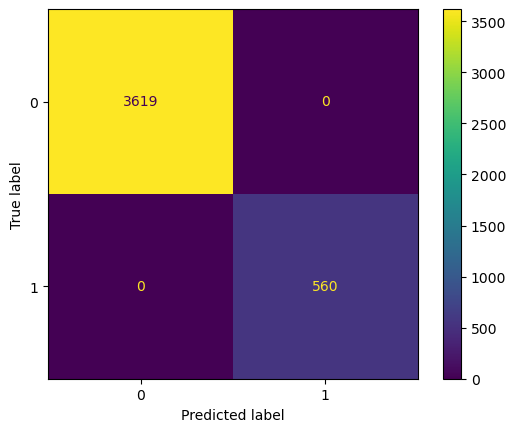

In [129]:
display_matrix_and_scores(y_train_true, y_train_pred)

Accuracy : 0.9827709978463748
Precision : 0.9222797927461139
Recall : 0.9518716577540107


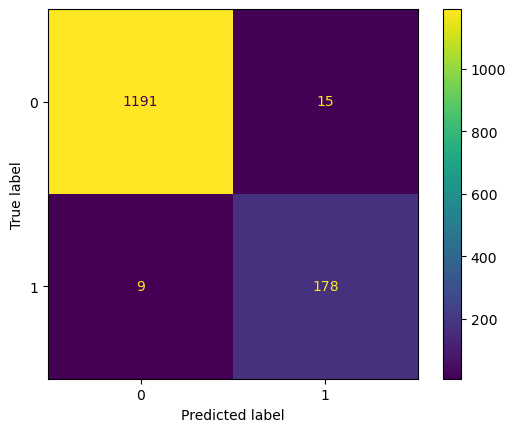

In [130]:
display_matrix_and_scores(y_test_true, y_test_pred)

Sur le modèle RNN avec le dataset en entier nous obtenons de très bon scores, avec un léger overfitting sur le train. Pour ordre de comparaison, il y autant de faux negatif mais plus de faux positif, cad que la precision est moins bonne donc il y a autant de spam qui sont reconnus mais il y a plus de sms ham qui sont classifier en spam.. le resultat est donc moins bon qu'un modèle plus simple. 

La loss est stable, decroissante et fini presque à 0

#### dataset undersampled

In [133]:
model_rnn_undersamp = tf.keras.Sequential([        
    tf.keras.layers.Embedding(vocab_size+1, 128, input_shape=[X_train.shape[1],],name="embedding"),
    tf.keras.layers.SimpleRNN(units=64, return_sequences=True),
    tf.keras.layers.SimpleRNN(units=32, return_sequences=False),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [134]:
model_rnn_undersamp.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          256128    
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 100, 64)           12352     
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_34 (Dense)            (None, 16)                528       
                                                                 
 dropout_15 (Dropout)        (None, 16)                0         
                                                                 
 dense_35 (Dense)            (None, 8)                 136       
                                                                 
 dropout_16 (Dropout)        (None, 8)                

In [140]:
core = {'dim_embedding':128,
        'nb_rnn_units':96,
        'nb_units_dense':25,
        'dropout':0.2}

callback_tb, callback_hp, log_dir = compile_logging(model=model_rnn_undersamp, model_name="RNN", metrics=metrics, core=core)

RNN logged


In [141]:
model_rnn_undersamp.fit(
    train_batch_undersampling,
    epochs=30,
    verbose=1,
    callbacks=[callback_tb, callback_hp],
    validation_data=val_batch_undersampling)

Epoch 1/30
30/30 [==============================] - 13s 417ms/step - loss: 0.5526 - accuracy: 0.7641 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5515 - val_accuracy: 0.7613 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
30/30 [==============================] - 12s 386ms/step - loss: 0.5545 - accuracy: 0.7621 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5522 - val_accuracy: 0.7613 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
30/30 [==============================] - 11s 378ms/step - loss: 0.5521 - accuracy: 0.7621 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5522 - val_accuracy: 0.7613 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
30/30 [==============================] - 12s 395ms/step - loss: 0.5523 - accuracy: 0.7621 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5513 - val_accuracy: 0.7613 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/30
30/30 [==================

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/models/

In [142]:
y_train_true, y_train_pred, y_test_true, y_test_pred = display_infos(model_rnn_undersamp, 0.5, X_train, X_test, y_train, y_test);

20/20 [==============================] - 1s 44ms/step
----------------------------------------
                 Sur le Train set            
----------------------------------------
loss = 0.5507515072822571
Accuracy = 0.7621098160743713
Precision = 0.0
Recall = 0.0

----------------------------------------
                 Sur le Test set            
----------------------------------------
loss = 0.5515830516815186
Accuracy = 0.7612903118133545
Precision = 0.0
Recall = 0.0


Accuracy : 0.7621097954790097
Precision : 0.0
Recall : 0.0


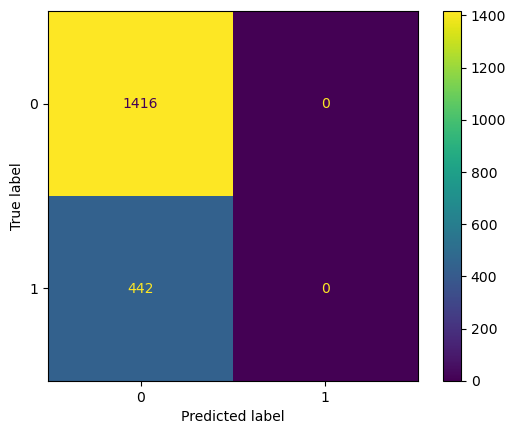

In [143]:
display_matrix_and_scores(y_train_true, y_train_pred)

Accuracy : 0.7612903225806451
Precision : 0.0
Recall : 0.0


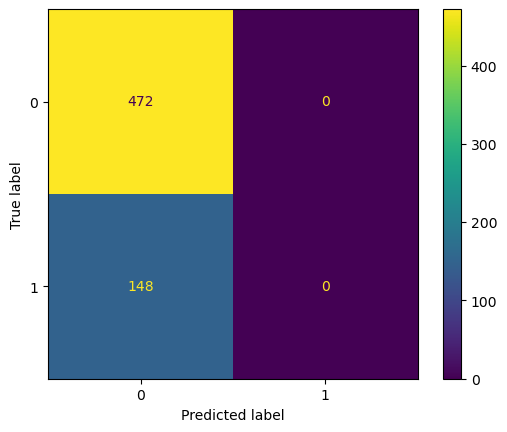

In [144]:
display_matrix_and_scores(y_test_true, y_test_pred)

On se retrouve face à un problème de compléxité : le modèle fait de l'underfitting cad qu'il n'arrive pas à trouver les bonnes classes, il devient "idiot" et classifie toujours la même classe, celle qui est majoritaire. Ce problème est difficile à résoudre : il peut provenir d'un problème de repartition de sample aléatoire (nous n'avons pas eu la chance d'avoir des samples représentant les spam qui font qu'il y a une logique dans la relation dans une sequence des vecteurs (cad il n'y a pas de relations entre les nombres d'une meme sequence qui permettent de prédire les spams). Peut être est-ce du à la regularisation des layers Dropout qui est trop élevé...retestons voir une autre valeur sur un autre shuffle

In [154]:
model2_rnn_undersamp = tf.keras.Sequential([        
    tf.keras.layers.Embedding(vocab_size+1, 128, input_shape=[X_train.shape[1],],name="embedding"),
    tf.keras.layers.SimpleRNN(units=64, return_sequences=True),
    tf.keras.layers.SimpleRNN(units=32, return_sequences=False),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [155]:
model2_rnn_undersamp.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 164, 128)          256128    
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 164, 64)           12352     
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_37 (Dense)            (None, 16)                528       
                                                                 
 dropout_17 (Dropout)        (None, 16)                0         
                                                                 
 dense_38 (Dense)            (None, 8)                 136       
                                                                 
 dense_39 (Dense)            (None, 1)                

In [156]:
core = {'dim_embedding':128,
        'nb_rnn_units':96,
        'nb_units_dense':25,
        'dropout':0.1}

callback_tb, callback_hp, log_dir = compile_logging(model=model2_rnn_undersamp, model_name="RNN", metrics=metrics, core=core)

RNN logged


In [157]:
model2_rnn_undersamp.fit(
    train_batch_undersampling,
    epochs=30,
    verbose=1,
    callbacks=[callback_tb, callback_hp],
    validation_data=val_batch_undersampling)

Epoch 1/30
36/36 [==============================] - 24s 612ms/step - loss: 0.5250 - accuracy: 0.7715 - precision: 0.2389 - recall: 0.0445 - val_loss: 0.5005 - val_accuracy: 0.8000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
36/36 [==============================] - 23s 629ms/step - loss: 0.5054 - accuracy: 0.7987 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5004 - val_accuracy: 0.8000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
36/36 [==============================] - 22s 618ms/step - loss: 0.5079 - accuracy: 0.8000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5006 - val_accuracy: 0.8000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
36/36 [==============================] - 22s 610ms/step - loss: 0.5036 - accuracy: 0.8000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5008 - val_accuracy: 0.8000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/30
36/36 [==========================

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/models/

In [158]:
y_train_true, y_train_pred, y_test_true, y_test_pred = display_infos(model2_rnn_undersamp, 0.5, X_train, X_test, y_train, y_test);

24/24 [==============================] - 2s 71ms/step
----------------------------------------
                 Sur le Train set            
----------------------------------------
loss = 0.5006378293037415
Accuracy = 0.800000011920929
Precision = 0.0
Recall = 0.0

----------------------------------------
                 Sur le Test set            
----------------------------------------
loss = 0.5006381869316101
Accuracy = 0.800000011920929
Precision = 0.0
Recall = 0.0


Accuracy : 0.8
Precision : 0.0
Recall : 0.0


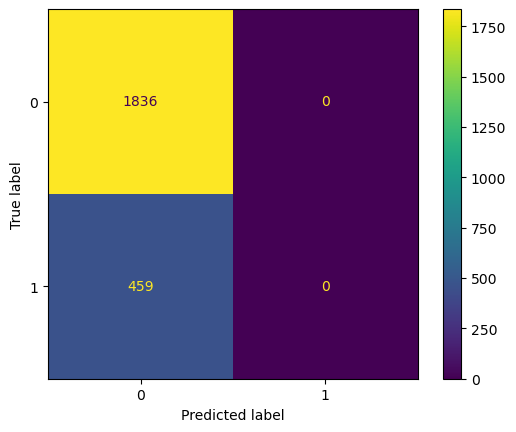

In [159]:
display_matrix_and_scores(y_train_true, y_train_pred)

Accuracy : 0.8
Precision : 0.0
Recall : 0.0


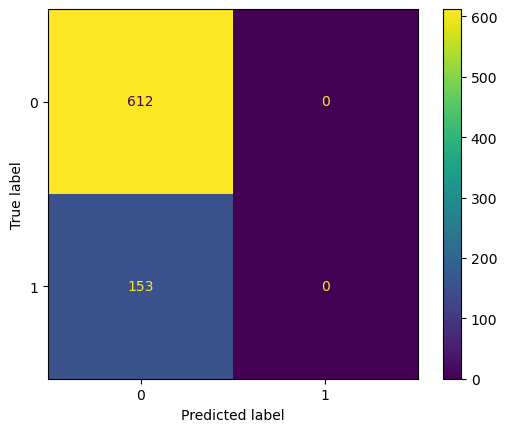

In [160]:
display_matrix_and_scores(y_test_true, y_test_pred)

On peut directement conclure que la technique de sous-echantillonnage (on se retrouve avec seulement 3000 samples : 600 spams et 24 hams) ne fonctionne pas car si l'on prend le dataset en entier nous obtenons de bien meilleurs résultats. Nous nous retrouvons dans le même cas qu'avant, cad que le modèle ne prédit que la classe majoritaire, donc ne prédit que des 0.

Nous allons tester de placer un Global Average Pooling en fin de reseau ce qui va permettre de flatten toute la séquence finale qui est retournée par les layers Dense. Après discussion, après avoir longuement réfléchi à une approche moins pragmatique des RNN, nous avons convenu de pouvoir garder la memoire le plus longtemps possible de le reseau de neurone, cad celle qui est contenue dans les layers de RNN, en faisant la moyenne sur la sequence entière

In [161]:
model_rnn_undersamp_average = tf.keras.Sequential([        
    keras.layers.Embedding(vocab_size+1, 128, input_shape=[X_train.shape[1],],name="embedding"),
    keras.layers.SimpleRNN(units=64, return_sequences=True),
    keras.layers.SimpleRNN(units=32, return_sequences=True),
    keras.layers.SimpleRNN(units=16, return_sequences=True),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1, activation="sigmoid")
])

In [162]:
core = {'dim_embedding':128,
        'nb_rnn_units':112,
        'nb_units_dense':1,
        'dropout':0.1}

callback_tb, callback_hp, log_dir = compile_logging(model=model_rnn_undersamp_average, model_name="RNN", metrics=metrics, core=core)

RNN logged


In [163]:
model_rnn_undersamp_average.fit(
    train_batch_undersampling,
    epochs=20,
    verbose=1,
    callbacks=[callback_tb, callback_hp],
    validation_data=val_batch_undersampling)

Epoch 1/20
36/36 [==============================] - 36s 955ms/step - loss: 0.4021 - accuracy: 0.8444 - precision: 0.7297 - recall: 0.3529 - val_loss: 0.3366 - val_accuracy: 0.8941 - val_precision: 0.7951 - val_recall: 0.6340
Epoch 2/20
36/36 [==============================] - 34s 934ms/step - loss: 0.3122 - accuracy: 0.9068 - precision: 0.8149 - recall: 0.6906 - val_loss: 0.3096 - val_accuracy: 0.9046 - val_precision: 0.8448 - val_recall: 0.6405
Epoch 3/20
36/36 [==============================] - 35s 986ms/step - loss: 0.2686 - accuracy: 0.9107 - precision: 0.7860 - recall: 0.7603 - val_loss: 0.2628 - val_accuracy: 0.9255 - val_precision: 0.8871 - val_recall: 0.7190
Epoch 4/20
36/36 [==============================] - 33s 919ms/step - loss: 0.2374 - accuracy: 0.9346 - precision: 0.8670 - recall: 0.7952 - val_loss: 0.3267 - val_accuracy: 0.8915 - val_precision: 0.6989 - val_recall: 0.8039
Epoch 5/20
36/36 [==============================] - 33s 928ms/step - loss: 0.2359 - accuracy: 0.9329

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/models/

In [164]:
y_train_true, y_train_pred, y_test_true, y_test_pred = display_infos(model2_rnn_undersamp, 0.5, X_train, X_test, y_train, y_test);

24/24 [==============================] - 2s 72ms/step
----------------------------------------
                 Sur le Train set            
----------------------------------------
loss = 0.5006378293037415
Accuracy = 0.800000011920929
Precision = 0.0
Recall = 0.0

----------------------------------------
                 Sur le Test set            
----------------------------------------
loss = 0.5006381869316101
Accuracy = 0.800000011920929
Precision = 0.0
Recall = 0.0


Accuracy : 0.8
Precision : 0.0
Recall : 0.0


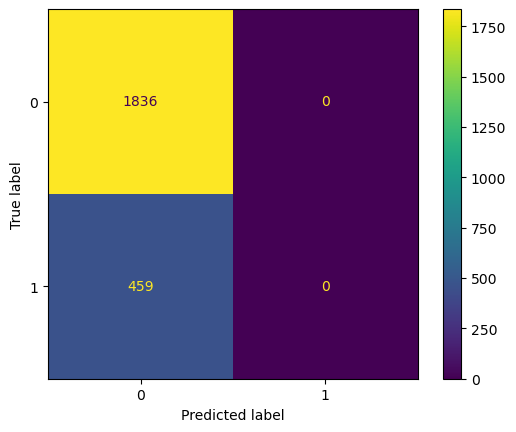

In [165]:
display_matrix_and_scores(y_train_true, y_train_pred)

Accuracy : 0.8
Precision : 0.0
Recall : 0.0


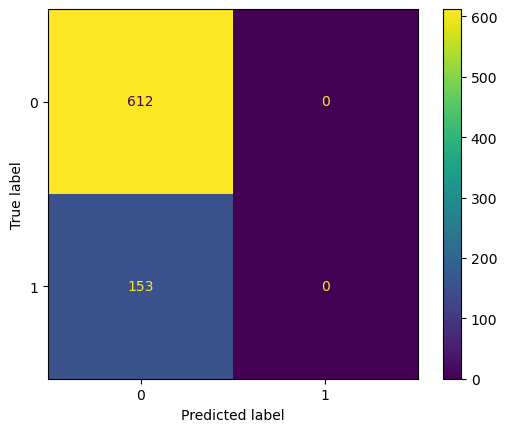

In [166]:
display_matrix_and_scores(y_test_true, y_test_pred)

Ces resultats n'etant pas concluant, nous allons rester avec notre dataset initial pour les prochains modèles

### Model 3 : LSTM

Les LSTM sont des cellules à mémoire interne mais qui possède 2 types de mémoire : une à court terme (comme les RNN) et une à long terme et utilise un mécanisme de portes de contrôle. Pour modéliser des dépendances à très long terme, il est nécessaire de donner aux réseaux de neurones récurrents la capacité de maintenir un état sur une longue période de temps.

C'est le but des cellules LSTM (Long Short Term Memory), qui possèdent une mémoire interne appelée cellule (ou cell). La cellule permet de maintenir un état aussi longtemps que nécessaire. Cette cellule consiste en une valeur numérique que le réseau peut piloter en fonction des situations. 

La cellule mémoire peut être pilotée par trois portes de contrôle qu'on peut voir comme des vannes :

* **porte d'entrée** : elle décide si l'**entrée doit modifier le contenu de la cellule** ;
* **porte d'oubli**  : elle décide s'il faut **remettre à 0 le contenu de la cellule** ;
* **porte de sortie**: elle décide si le **contenu de la cellule doit influer sur la sortie du neurone**.

Le mécanisme des trois portes est strictement similaire. L'**ouverture/fermeture** de la vanne est modélisée par une fonction f qui est généralement une **sigmoïde**

Les sorties de tous les neurones sont réinjectées en entrée de tous les neurones.

Afin de réduire le nombre de paramètres des modèles, il existe une variante des LSTM appelée GRU (Gated Recurrent Unit), qui supprime la porte d'oubli. Il a été montré qu'on obtenait des performances quasiment similaires avec moins de paramètres.

Créons donc notre reseau de neurone composées de layers LSTM qui va prendre en entrée une layer d'Embedding (nous allons tester seulement de mapper en 32 dimensions chaque vecteur) puis on y ajoute une layer LSTM avec 64 unités : chaque sortie de chaque neurone est réinjectée en entrée de tous les neurones. Nous allons aussi l'applatir pour la faire passer dans une layer Dense comportant 250 neurones que l'on va decomplexifier par un facteur de 40% puis une autre Dense de 120 pour enfin terminer par une unique Dense pour la classification binaire avec encore une fois une fonction d'activation Sigmoid

In [167]:
model_lstm = tf.keras.Sequential([
    keras.layers.Embedding(max_words, 32, input_length=max_len),
    keras.layers.LSTM(64),
    keras.layers.Flatten(),
    keras.layers.Dense(250, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(120, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

Nous allons changer de technique : pour l'optimizer, nous allons passer à RMSProp car il est recommandé pour les réseaux de neurones récurrents.

In [168]:
metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'), 
           tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall')]

model_lstm.compile(loss='binary_crossentropy',
              optimizer='RMSprop',
              metrics=metrics)

In [169]:
model_lstm.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 164, 32)           64000     
                                                                 
 lstm_1 (LSTM)               (None, 64)                24832     
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_41 (Dense)            (None, 250)               16250     
                                                                 
 dropout_19 (Dropout)        (None, 250)               0         
                                                                 
 dense_42 (Dense)            (None, 120)               30120     
                                                                 
 dense_43 (Dense)            (None, 1)               

In [175]:
callback_tb, callback_hp, log_dir = compile_logging(model=model_lstm, model_name="LSTM", metrics=metrics, core={'dim_embedding':256, 'nb_dense_units':233, 'dropout':0.35});

LSTM logged


In [179]:
with tf.device('/CPU:0'):
    model_lstm.fit(
            train_batch_total,
            epochs=20,
            verbose=1,
            callbacks=[callback_tb, callback_hp],
            validation_data=val_batch_total)

Epoch 1/20
70/70 [==============================] - 5s 72ms/step - loss: 0.1500 - accuracy: 0.9475 - precision: 0.9174 - recall: 0.6689 - val_loss: 0.0441 - val_accuracy: 0.9883 - val_precision: 0.9857 - val_recall: 0.9262
Epoch 2/20
70/70 [==============================] - 5s 71ms/step - loss: 0.0326 - accuracy: 0.9897 - precision: 0.9742 - recall: 0.9482 - val_loss: 0.0415 - val_accuracy: 0.9901 - val_precision: 0.9662 - val_recall: 0.9597
Epoch 3/20
70/70 [==============================] - 5s 71ms/step - loss: 0.0177 - accuracy: 0.9962 - precision: 0.9949 - recall: 0.9766 - val_loss: 0.0520 - val_accuracy: 0.9857 - val_precision: 0.9290 - val_recall: 0.9664
Epoch 4/20
70/70 [==============================] - 5s 70ms/step - loss: 0.0115 - accuracy: 0.9971 - precision: 0.9949 - recall: 0.9833 - val_loss: 0.0575 - val_accuracy: 0.9857 - val_precision: 0.9290 - val_recall: 0.9664
Epoch 5/20
70/70 [==============================] - 5s 72ms/step - loss: 0.0069 - accuracy: 0.9982 - precisi

In [180]:
with tf.device('/CPU:0'):
    model_lstm.fit(
            train_batch_total,
            epochs=20,
            verbose=1,
            callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)],
            validation_data=val_batch_total)

Epoch 1/20
70/70 [==============================] - 5s 73ms/step - loss: 0.0012 - accuracy: 0.9998 - precision: 1.0000 - recall: 0.9983 - val_loss: 0.0946 - val_accuracy: 0.9883 - val_precision: 0.9474 - val_recall: 0.9664
Epoch 2/20
70/70 [==============================] - 5s 72ms/step - loss: 0.0011 - accuracy: 0.9998 - precision: 1.0000 - recall: 0.9983 - val_loss: 0.0965 - val_accuracy: 0.9892 - val_precision: 0.9536 - val_recall: 0.9664


[tf.keras.callbacks.EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) : Stop l'entrainement lorsqu'il n'y a plus d'amélioration de la metric 'monitor'

In [181]:
y_train_true, y_train_pred, y_test_true, y_test_pred = display_infos(model2_rnn_undersamp, 0.5, X_train, X_test, y_train, y_test);

24/24 [==============================] - 2s 77ms/step
----------------------------------------
                 Sur le Train set            
----------------------------------------
loss = 0.5006378293037415
Accuracy = 0.800000011920929
Precision = 0.0
Recall = 0.0

----------------------------------------
                 Sur le Test set            
----------------------------------------
loss = 0.5006381869316101
Accuracy = 0.800000011920929
Precision = 0.0
Recall = 0.0


Accuracy : 0.8
Precision : 0.0
Recall : 0.0


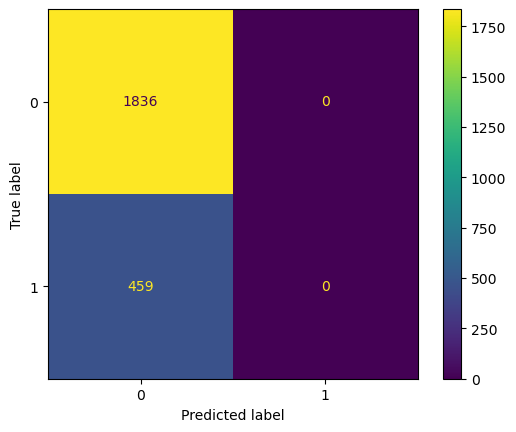

In [182]:
display_matrix_and_scores(y_train_true, y_train_pred)

Accuracy : 0.8
Precision : 0.0
Recall : 0.0


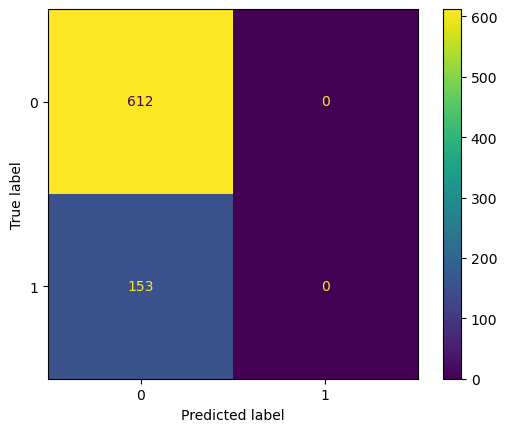

In [183]:
display_matrix_and_scores(y_test_true, y_test_pred)

Toujours pareil.. de très bons score pour l'accuracy en général mais très mauvais en precision et recall..changeons de reseau de neurones

### Model 2 

Avec une layer de TextVectorization

In [185]:
max_words = 1000
max_len = 200

text_vectorized = tf.keras.layers.TextVectorization(
    max_tokens=max_words,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=max_len
)

text_vectorized.adapt(X_train_total)

ValueError: in user code:

    File "C:\Users\david\anaconda3\lib\site-packages\keras\engine\base_preprocessing_layer.py", line 118, in adapt_step  *
        self.update_state(data)
    File "C:\Users\david\anaconda3\lib\site-packages\keras\layers\preprocessing\text_vectorization.py", line 431, in update_state  **
        self._lookup_layer.update_state(self._preprocess(data))
    File "C:\Users\david\anaconda3\lib\site-packages\keras\layers\preprocessing\text_vectorization.py", line 521, in _preprocess
        raise ValueError(

    ValueError: When using `TextVectorization` to tokenize strings, the input rank must be 1 or the last shape dimension must be 1. Received: inputs.shape=(None, 164) with rank=2


In [77]:
embedding_layer = tf.keras.layers.Embedding(
    input_dim=max_words,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=max_len
)

In [78]:
input_layer = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
vector_layer = text_vectorized(input_layer)
embedding_layer_model = embedding_layer(vector_layer)

x = tf.keras.layers.GlobalAveragePooling1D()
x = x(embedding_layer_model)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)

output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_2 = keras.Model(input_layer, output_layer)

In [82]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 200)              0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 200, 128)          128000    
                                                                 
 global_average_pooling1d_2   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 flatten_2 (Flatten)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 32)                4128

In [79]:
model_2.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.BinaryCrossentropy(label_smoothing=0.5),
                metrics=['accuracy'])

In [80]:
history_2 = model_2.fit(X_train,
                        y_train,
                        epochs=10,
                        validation_data=(X_test, y_test),
                        validation_steps=int(0.2 * len(X_test)))

Epoch 1/10
140/140 [==============================] - 2s 14ms/step - loss: 0.6303 - accuracy: 0.8544 - val_loss: 0.6186 - val_accuracy: 0.8664
Epoch 2/10
140/140 [==============================] - 2s 12ms/step - loss: 0.6141 - accuracy: 0.8658 - val_loss: 0.6050 - val_accuracy: 0.8664
Epoch 3/10
140/140 [==============================] - 2s 12ms/step - loss: 0.5915 - accuracy: 0.9174 - val_loss: 0.5873 - val_accuracy: 0.9677
Epoch 4/10
140/140 [==============================] - 2s 11ms/step - loss: 0.5792 - accuracy: 0.9697 - val_loss: 0.5772 - val_accuracy: 0.9704
Epoch 5/10
140/140 [==============================] - 2s 12ms/step - loss: 0.5750 - accuracy: 0.9771 - val_loss: 0.5753 - val_accuracy: 0.9776
Epoch 6/10
140/140 [==============================] - 2s 11ms/step - loss: 0.5731 - accuracy: 0.9812 - val_loss: 0.5737 - val_accuracy: 0.9821
Epoch 7/10
140/140 [==============================] - 2s 12ms/step - loss: 0.5724 - accuracy: 0.9823 - val_loss: 0.5722 - val_accuracy: 0.9821

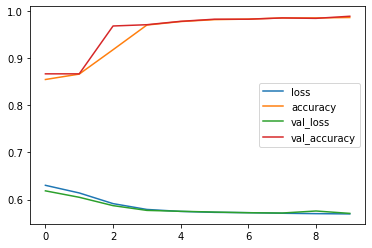

In [81]:
pd.DataFrame(history_2.history).plot();

### Model 3

Bi-LSTM Model

In [86]:
input_layer = tf.keras.layers.Input(shape=(1,), dtype=tf.string) 

vector_layer = text_vectorized(input_layer) 
embedding_layer_model = embedding_layer(vector_layer) 

bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation='tanh', return_sequences=True))(embedding_layer_model) 
lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(bi_lstm)

flatten = tf.keras.layers.Flatten()(lstm) 

dropout = tf.keras.layers.Dropout(.2)(flatten) 

x = tf.keras.layers.Dense(32, activation='relu')(dropout) 

output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x) 

In [87]:
model_3 = tf.keras.Model(input_layer, output_layer) 

In [88]:
model_3.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.BinaryCrossentropy(label_smoothing=0.5),
                metrics=['accuracy'])

In [90]:
history_3 = model_3.fit(X_train,
                        y_train,
                        epochs=10,
                        validation_data=(X_test, y_test),
                        validation_steps=int(0.2*len(X_test)))

Epoch 1/10
140/140 [==============================] - 15s 74ms/step - loss: 0.5711 - accuracy: 0.9868 - val_loss: 0.5678 - val_accuracy: 0.9883
Epoch 2/10
140/140 [==============================] - 9s 65ms/step - loss: 0.5667 - accuracy: 0.9904 - val_loss: 0.5742 - val_accuracy: 0.9740
Epoch 3/10
140/140 [==============================] - 9s 65ms/step - loss: 0.5660 - accuracy: 0.9933 - val_loss: 0.5713 - val_accuracy: 0.9812
Epoch 4/10
140/140 [==============================] - 9s 66ms/step - loss: 0.5655 - accuracy: 0.9935 - val_loss: 0.5697 - val_accuracy: 0.9830
Epoch 5/10
140/140 [==============================] - 9s 66ms/step - loss: 0.5653 - accuracy: 0.9944 - val_loss: 0.5675 - val_accuracy: 0.9910
Epoch 6/10
140/140 [==============================] - 9s 64ms/step - loss: 0.5643 - accuracy: 0.9966 - val_loss: 0.5683 - val_accuracy: 0.9874
Epoch 7/10
140/140 [==============================] - 9s 66ms/step - loss: 0.5643 - accuracy: 0.9964 - val_loss: 0.5706 - val_accuracy: 0.983

In [94]:
y_preds = np.round(model_3.predict(X_test))
accuracy = accuracy_score(y_test, y_preds)
precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds)

35/35 [==============================] - 1s 22ms/step


In [97]:
print('accuracy  : ',accuracy)
print('precision : ',precision)
print('recall    : ',recall)
print('f1-score  : ',f1)

accuracy  :  0.9883408071748879
precision :  0.9473684210526315
recall    :  0.9664429530201343
f1-score  :  0.9568106312292358


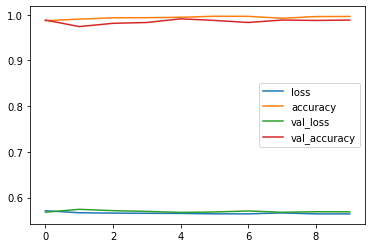

In [98]:
pd.DataFrame(history_3.history).plot();